In [75]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special

In [199]:
time = 2*np.pi # total time in seconds
dt=0.1 # Timestep
nt = int(time / dt) # number of time steps
t0=0; theta0=np.pi*0.1; #Initial time and value

order = 4 # order of symplectic integrator

k = 1.0 # define k
g = 10 # define g for energy analysis

t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

In [200]:
# Euler's method
def euler(t,k,dt,theta0):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    
    for i in range(nt-1):
        u[i+1] = u[i] - dt*np.sin(theta[i])*k**2
        #theta[i+1] = theta[i] + dt*u[i] # Euler's method
        theta[i+1] = theta[i] + dt*u[i+1] # Semi-implicit Euler's method
        
    return [theta,u]
    
thetaEuler,uEuler = euler(t,k,dt,theta0)

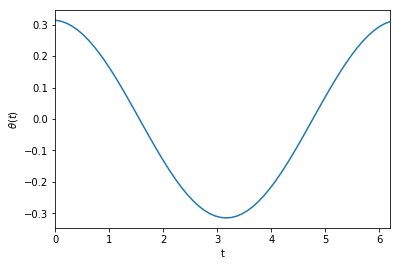

In [201]:
#Plot the result of Euler's method
plt.plot(t,thetaEuler)
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.show()

In [203]:
# Symplectic integrator coefficients
# 1st order: ci = [1 0 0 0] di = [1 0 0 0] 
# 2nd order: ci = [0 1 0 0] di = [0.5 0.5 0 0] 
# 3rd order: ci = [1 -2/3 2/3 0] di = [-1/24 3/4 7/24 0] 
# 4th order: let x = 2-2^(1/3) c1=c4=1/2x, c2=c3=[1-2^(1/3)]/2x, d1=d3=1/x d2=-2^(1/3)/x  d4=0

def symplectic(t,k,dt,theta0,order):
    
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    
    if (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
        
    for i in range(nt-1):

        theta[i+1] = theta[i] + c[0]*dt*u[i]
        u[i+1] = u[i] - d[0]*dt*np.sin(theta[i+1])*k**2
              
        theta[i+1] = theta[i+1] + c[1]*dt*u[i+1]
        u[i+1] = u[i+1] - d[1]*dt*np.sin(theta[i+1])*k**2
        
        theta[i+1] = theta[i+1] + c[2]*dt*u[i+1]
        u[i+1] = u[i+1] - d[2]*dt*np.sin(theta[i+1])*k**2
    
        theta[i+1] = theta[i+1] + c[3]*dt*u[i+1]
        u[i+1] = u[i+1] - d[3]*dt*np.sin(theta[i+1])*k**2
        
    return [theta,u]
    
thetaSym,uSym = symplectic(t,k,dt,theta0,order)

0.314159265359
0.314892491124
0.314699825866
0.312615422742


0.310531019618
0.31179783319
0.312147556742
0.307998573265


0.303849589788
0.305637919946
0.306526704531
0.30035265575


0.294178606969
0.296471365528
0.297890749356
0.289750577357


0.281610405357
0.28438560682
0.286322050633
0.276293716519


0.266265382406
0.26949630473
0.271931284535
0.26011120677


0.248291129004
0.25194651877
0.25485665737
0.24135898408


0.227861310789
0.231905635855
0.235262876275
0.220218579225


0.205174282175
0.209568034253
0.213339858326
0.196895638126


0.180451417925
0.185151466384
0.189301161443
0.171618157193


0.153935152943
0.158895149645
0.163382125482
0.144634427401


0.12588672932
0.131057562429
0.135837719466
0.116210689663


0.0965836598588
0.101913952576
0.106940100579
0.0866285146923


0.0663169288051
0.0717535769343
0.0769759017028
0.0561819319918


0.0353879622808
0.0408767026345
0.0462432760779
0.0251743440761


0.00410541207427
0.00959141216509
0.0150487391605
-0.00608472741679



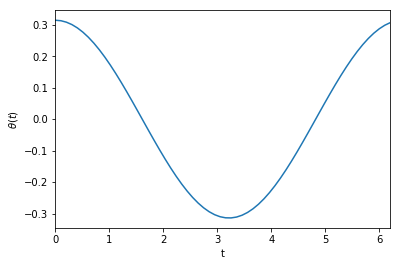

In [190]:
#Plot the result of symplectic integrator
plt.plot(t,thetaSym)
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.show()

In [191]:
# Analytical solution

def analytical(t,k,theta0):

    x = np.sin(theta0/2)
    eK = sp.special.ellipk(x**2) # complete elliptic integral of the first kind
    eJ = sp.special.ellipj(eK - k*t, x**2) # Jacobian elliptic function
    thetaAna = 2*np.arcsin(x*eJ[0]) # ellipj returns 4 values, we only need 1st
    
    return thetaAna

thetaAna = analytical(t,k,theta0)
uAna = np.gradient(thetaAna,dt)

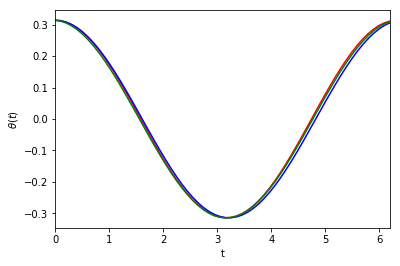

In [192]:
#Plot the result
plt.plot(t,thetaAna,color='r') #Analytical solution is red
plt.plot(t,thetaSym,color='b') # Symplectic solution is blue
plt.plot(t,thetaEuler,color='g') # Euler solution is green
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.show()

In [193]:
def energy(u,theta):
    
    return g**2/k**2*(1/(2*k**2)*u**2-np.cos(theta))

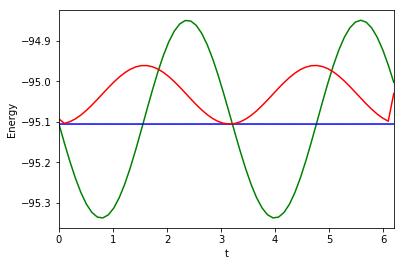

In [194]:
energyEuler = energy(uEuler,thetaEuler)
energySym = energy(uSym,thetaSym)
energyAna = energy(uAna,thetaAna)
  
plt.plot(t,energyEuler, color = 'g')
plt.plot(t,energySym, color = 'b')
plt.plot(t,energyAna, color = 'r')

plt.xlabel('t')
plt.ylabel('Energy')
plt.xlim(0,dt*nt)
plt.show()

-0.00175583768552
-0.00529559315108


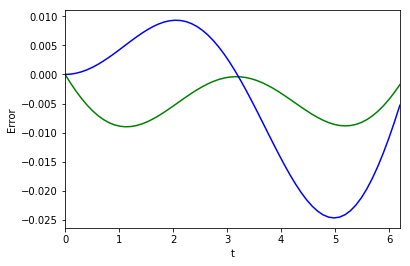

In [195]:
#Plot the error
errEuler = thetaEuler - thetaAna
errSym = thetaSym - thetaAna

print(errEuler[-1])
print(errSym[-1])

plt.plot(t,errEuler, color = 'g') # Euler function error is green
plt.plot(t,errSym, color = 'b') # Symplectic error is blue
plt.xlabel('t')
plt.ylabel('Error')
plt.xlim(0,dt*nt)
plt.show()

In [196]:
def errorCalc(tvec,err):
    bound = np.r_[True, err[0:-2] < err[1:-1]] & np.r_[err[1:-1] < err[0:-2], True]
    bound = np.append(bound,False)
    localErr = np.polyfit(tvec[bound], err[bound],1)
    
    return localErr

0
1
2
3
4
5
6
7
8
9
10
11
12
13
[  1.80588057e-03   1.23543732e-03   2.17164870e-04   1.21719680e-04
   7.30472352e-05   4.85200567e-05   3.62145818e-05   1.77087348e-05
   8.67424381e-06   4.21164273e-06   1.99400784e-06   8.88607374e-07
   3.36761454e-07   2.44859739e-07]
[  5.75856529e-03   2.56339886e-03   5.69575894e-04   2.59062300e-04
   1.32052926e-04   7.56128065e-05   4.91592254e-05   2.38834214e-05
   1.16872142e-05   5.69953923e-06   2.73330947e-06   1.25709661e-06
   5.20715705e-07   3.36800203e-07]


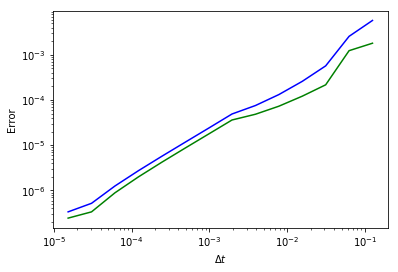

In [197]:
j = np.linspace(3,16,14)
h = 2**(-j)

errE = np.zeros(h.size)
errS = np.zeros(h.size)

for i in range(h.size):
    print(i)
    nt = int(time / h[i])
    tvec = np.linspace(t0,time,nt)
    
    thetaE = euler(tvec,k,h[i],theta0)[0]
    thetaS = symplectic(tvec,k,h[i],theta0,order)[0]
    thetaA = analytical(tvec,k,theta0)
    
    errorE = thetaE - thetaA
    errorS = thetaS - thetaA
    
    errE[i] = np.abs(errorE[-1])
    errS[i] = np.abs(errorS[-1])
    #errE[i] = np.abs(errorCalc(tvec,errorE)[0])
    #errS[i] = np.abs(errorCalc(tvec,errorS)[0])
    
print(errE)
print(errS)

slopeE = np.polyfit(np.log(h),np.log(errE),1)
slopeS = np.polyfit(np.log(h),np.log(errS),1)

plt.loglog(h,errE,color='g')
plt.loglog(h,errS,color='b')
plt.xlabel(r'$\Delta t$')
plt.ylabel('Error')
plt.show()

In [198]:
slopeE = np.polyfit(np.log(h),np.log(errE),1)
slopeS = np.polyfit(np.log(h),np.log(errS),1)

print(slopeE)
print(slopeS)

[ 0.96541943 -4.52176672]
[ 1.04371311 -3.48712645]
